# Hyperopt notebook
Hyperopt is a Python library for serial and parallel optimization over awkward search spaces, which may include real-valued, discrete, and conditional dimensions.
In this notebook, the basics are covered and advanced features will be explored. Everything here will be done with the idea of applying hyperopt to hyper-parameter tuning of Keras models (usin TF2.1) (although generalization is persued for other cases as well).

## 1.- Basic

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pickle
from collections import OrderedDict 

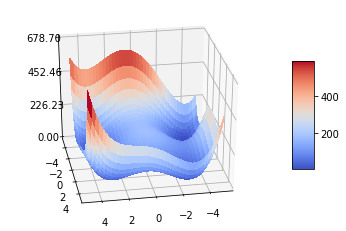

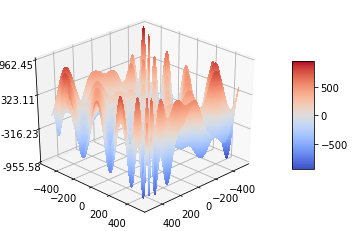

-384.28559851011784

In [3]:
# define a complicated objective function
def himmelblau_function(x, y):
    return (x**2 + y -11)**2 + (x + y**2 - 7)**2

def eggholder_function(x, y):
    return -(y + 47)*np.sin(np.sqrt(np.abs((x/2) + (y + 47)))) - x*np.sin(np.sqrt(np.abs(x - y + 47)))

def plot_3d_surface(f,  limits, angle=90):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    # Make data
    lower_, upper_, step_ = limits
    X = np.arange(lower_, upper_, step_)
    Y = np.arange(lower_, upper_, step_)
    X, Y = np.meshgrid(X, Y)
    Z = f(X, Y)
    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                          rstride=1, cstride=1)
    # Customize the z axis.
    ax.set_zlim(np.min(Z), np.max(Z))
    ax.zaxis.set_major_locator(LinearLocator(4))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.view_init(30, angle)
    plt.show()
plot_3d_surface(himmelblau_function, [-5, 5, 0.25], 80)
himmelblau_function(3,2)
plot_3d_surface(eggholder_function, [-512, 512, 1], 45)
eggholder_function(512, 404.2319)

In [4]:
# define an objective function
def objective(args):
    case, val = args
    if case == 'case 1':
        return val
    else:
        return val ** 2
# define a search space
from hyperopt import hp
space = hp.choice(
    'a',
    [
        ('case 1', 1 + hp.lognormal('c1', 0, 1)),
        ('case 2', hp.uniform('name', -10, 10))
    ])
# minimize the objective over the space
from hyperopt import fmin, tpe, space_eval
best = fmin(objective, space, algo=tpe.suggest, max_evals=2000)
print(best)
# -> {'a': 1, 'c2': 0.01420615366247227}
print(space_eval(space, best))
# -> ('case 2', 0.01420615366247227}

100%|██████████| 2000/2000 [00:15<00:00, 129.72trial/s, best loss: 1.398866319036527e-09]
{'a': 1, 'name': -3.740142135048516e-05}
('case 2', -3.740142135048516e-05)


## 2.- Search space
A search space is a dictionary or OrderedDict as in this case with the hyper-params ranges.
### 2.1.- Uniform range or prob distribution (float)
    - hp.randint(label, upper)
    - hp.uniform(label, low, high)
    - hp.loguniform(label, low, high)
    - hp.normal(label, mu, sigma)
    - hp.lognormal(label, mu, sigma)
### 2.2.- Quantized parameters (int)
    - hp.quniform(label, low, high, q)
    - hp.qloguniform(label, low, high, q)
    - hp.qnormal(label, mu, sigma, q)
    - hp.qlognormal(label, mu, sigma, q)
### 2.3.- Categorical parameters (choices)
    - hp.choice(label, ["list", "of", "potential", "choices"])
    - hp.choice(label, [hp.uniform(sub_label_1, low, high), hp.normal(sub_label_2, mu, sigma), None, 0, 1, "anything"])

In [5]:
SEARCH_SPACE = OrderedDict([('learning_rate',
                             hp.loguniform('learning_rate', np.log(0.01), np.log(0.5))),
                            ('epochs',
                             hp.choice('epochs', range(1, 51, 1))),
                            ('batch_size',
                             hp.choice('batch_size', [32, 64, 128, 256, 512])),
                            ('l1_reg',
                             hp.choice('l1_reg', np.arange(1e-5, 2e-4, 1e-6)))
                           ])

## 3. Objective function
Remember that hyperopt minimizes the function, so change the sign if you need to.

In [13]:
STATIC_PARAMS = {'boosting': 'gbdt',
                'objective':'binary',
                'metric': 'auc',
                'num_threads': 12,
                }
def objective(params):
    all_params = {**params, **STATIC_PARAMS}
    return -1.0 * train_evaluate(all_params)

## 4. Instantiate Trials object and run optimization
This will record the history of every trial

### 4.1.- Data and model:

In [15]:
from tflite2xcore.model_generation import utils
import tensorflow as tf
utils.set_all_seeds(42)
# Data
data = utils.prepare_MNIST(False, simard=False, padding=0)

for k, v in data.items():
    print(f"Prepped data[{k}] with shape: {v.shape}")


def train_evaluate(params):
    '''
    data:
    'x_train'
    'y_train'
    'x_test'
    'y_test'
    params:
    'learning_rate'
    'epochs'
    'batch_size'
    'l1_norm'
    '''

    ''' MNIST
    tf.keras.Sequential(
        name='hyperopt_test',
        layers=[
            tf.keras.layers.Flatten(input_shape=(32, 32, 1), name='input'),
            tf.keras.layers.Dense(390, activation='tanh', name='dense_1'),
            tf.keras.layers.Dense(290, activation='tanh', name='dense_2'),
            tf.keras.layers.Dense(10, activation='softmax', name='output')
        ])
    '''
    core_model = tf.keras.Sequential(
        name='logistic_regression',
        layers=[
            tf.keras.layers.Flatten(input_shape=(28, 28, 1), name='input'),
            tf.keras.layers.Dense(10,
                                  activation='softmax',
                                  kernel_regularizer=tf.keras.regularizers.l1(params['l1_reg']))
        ]
    )
    core_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=params['learning_rate']),
        metrics=['accuracy'])
    core_model.fit(
        data['x_train'], data['y_train'],
        validation_data=(data['x_test'], data['y_test']),
        batch_size=params['batch_size'],
        verbose=0,
        epochs=params['epochs']
    )
    _, accuracy = core_model.evaluate(data['x_test'], data['y_test'])
    return accuracy

Prepped data[x_train] with shape: (4096, 28, 28, 1)
Prepped data[x_test] with shape: (1024, 28, 28, 1)
Prepped data[x_val] with shape: (100, 28, 28, 1)
Prepped data[y_train] with shape: (4096,)
Prepped data[y_test] with shape: (1024,)
Prepped data[y_val] with shape: (100,)


In [16]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL
trials = Trials()
HPO_PARAMS = {'max_evals': 1000,
              'trials': trials
             }
best = fmin(
    fn=objective,
    space=SEARCH_SPACE,
    algo=tpe.rand.suggest,
    **HPO_PARAMS
)

  32/1024 [..............................]              
 - ETA: 1s - loss: 0.2911 - accuracy: 0.9688            
                                                       
1024/1024 [==============================]              
 - 0s 62us/sample - loss: 0.7796 - accuracy: 0.8438     

  32/1024 [..............................]                              
 - ETA: 1s - loss: 4.0001 - accuracy: 0.9375                            
                                                                       
1024/1024 [==============================]                              
 - 0s 61us/sample - loss: 6.8673 - accuracy: 0.8525                     

  32/1024 [..............................]                                   
 - ETA: 1s - loss: 7.3603 - accuracy: 0.8125                                 
                                                                            
1024/1024 [==============================]                                   
 - 0s 59us/sample - loss: 9.8185 - accu

In [17]:
print(f"Found minimum after {HPO_PARAMS['max_evals']} trials:")
print(best)
print("")
print(space_eval(SEARCH_SPACE, best))

Found minimum after 1000 trials:
{'batch_size': 4, 'epochs': 27, 'l1_reg': 177, 'learning_rate': 0.015748174313155228}

{'batch_size': 512, 'epochs': 28, 'l1_reg': 0.0001870000000000001, 'learning_rate': 0.015748174313155228}


In [18]:
best_params = space_eval(SEARCH_SPACE, best)

In [40]:
l = [-objective(best_params) for e in range(50)]

1024/1024 [==============================] - 0s 62us/sample - loss: 0.4822 - accuracy: 0.8994


In [48]:
maxv = np.max(l)
minv = np.min(l)
print(f"Acc range: ({maxv}, {minv})\nAcc median: {np.median(l)}")

Acc range: (0.9013671875, 0.8837890625)
Acc median: 0.896484375


## 5. Save pickle

In [49]:
from sklearn.externals import joblib
joblib.dump(trials, 'hyperopt_trials.pkl') # imagine max_evals = 100

TypeError: file must have a 'write' attribute

## 6. Load pickle

In [ ]:
trials = joblib.load('./hyperopt_trials.pkl')
#_ = fmin(objective, SPACE, trials=trials, algo=tpe.rand.suggest, max_evals=200) -> we can add content

## 5. Visualization

avg best error: -0.9013671875


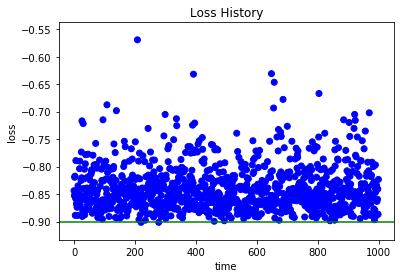

Showing Histogram of 1000 jobs


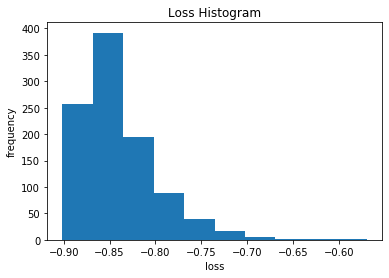

In [60]:
from hyperopt import plotting
plotting.main_plot_history(trials)
plotting.main_plot_histogram(trials)